In [40]:
#Import required libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')


In [2]:
#Importing Data
db_dir = os.getcwd()
db_dir = db_dir + '/MMA860_Assignment1_Data_vf.xlsx'
dfWindfarmTurbineLocations = pd.read_excel(db_dir, sheet_name='Windfarm Turbine Locations')
dfTurbineSpecifications = pd.read_excel(db_dir, sheet_name='Turbine Specifications')
dfIslandAirportWeather = pd.read_excel(db_dir, sheet_name='Island Airport Weather',skiprows=16)
dfProductSales = pd.read_excel(db_dir, sheet_name='Product_Sales')
dfCollinearity = pd.read_excel(db_dir, sheet_name='Collinearity')

In [3]:
#question 1a
# Since our weather data doesn’t include “air density”, you will need to calculate it 
# for each hour of data using the following formula and save it to a new variable and print out the first 5 records. 2 marks
# Air density (kg/m^3)=([Stn Press (kPa)]  ×1000)/(287.05×([Temp (°C)]+273.15))

dfIslandAirportWeather['Air density'] = (dfIslandAirportWeather['Stn Press (kPa)']*1000)/(287.05*(dfIslandAirportWeather['Temp (°C)']+273.15))
dfIslandAirportWeather.head(5)

,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),...,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Air density
0,1,1,00:00:00,4.3,NaN,4.0,NaN,98,NaN,8.0,...,4.8,NaN,98.49,NaN,NaN,NaN,NaN,NaN,"Rain,Fog",1.236659
1,1,1,01:00:00,5.1,NaN,5.0,NaN,99,NaN,NaN,...,16.1,NaN,98.47,NaN,NaN,NaN,NaN,NaN,NaN,1.232853
2,1,1,02:00:00,5.9,NaN,5.6,NaN,98,NaN,31.0,...,4.0,NaN,98.57,NaN,NaN,NaN,NaN,NaN,"Rain,Fog",1.230567
3,1,1,03:00:00,3.3,NaN,2.6,NaN,95,NaN,30.0,...,16.1,NaN,98.98,NaN,NaN,NaN,NaN,NaN,NaN,1.247307
4,1,1,04:00:00,2.8,NaN,1.2,NaN,89,NaN,30.0,...,16.1,NaN,99.29,NaN,NaN,NaN,NaN,NaN,NaN,1.253480


In [4]:
# b.	Windspeed [Wind Spd (km/h)] will need to be converted from km/h to meters per second for each hour of data (1 km/h ≈ 0.277778 m/s). S
# ave this to a new variable and print out the first 5 results. Include entries even if no power was generated. 2 marks

dfIslandAirportWeather['Wind Spd (m/s)'] = (dfIslandAirportWeather['Wind Spd (km/h)']*0.277778)
#Quality Check
selected_rows = dfIslandAirportWeather[['Wind Spd (km/h)','Wind Spd (m/s)']]
selected_rows.head(5)


,Wind Spd (km/h),Wind Spd (m/s)
0,11,3.055558
1,4,1.111112
2,28,7.777784
3,34,9.444452
4,28,7.777784


In [78]:
# c.	To calculate the power production at each turbine, use the following formula, keeping the following points in mind, save it to a new variable 
#       and print out the first 5 records. 3 marks
#       power (watts)=[Air density]× [Turbine swept area]  ×0.5[Wind speed (m/s)]^3  ×[Maximum power coefficient]
            # Points:
            # i.	If the windspeed is above or below the minimum and maximum cutoff speeds, the wind turbines will not operate
            # ii.	Each turbine cannot produce more than [Turbine nominal power] at any given point in time. Note that [Turbine nominal power] is 
            #       given in Megawatts, where your power calculation is in watts (1 MW = 1,000,000 watts)
            
import numpy as np
TurbineSweptArea = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Turbine swept area'][['Values']]
MinCutoffSpeed = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Cut-in windspeed (m/s)'][['Values']]
MaxCutoffSpeed = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Cut-out windspeed (m/s)'][['Values']]
Maximumpowercoefficient = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Maximum power coefficient'][['Values']]
#conversion Megawatts to Watts
Turbinenominalpower = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Turbine nominal power'][['Values']]*1000000

#covert for sql
dfIslandAirportWeather.to_sql('dfIslandAirportWeather', con=engine, if_exists='replace', index=False)
MinCutoffSpeed.to_sql('MinCutoffSpeed', con=engine, if_exists='replace', index=False)
MaxCutoffSpeed.to_sql('MaxCutoffSpeed', con=engine, if_exists='replace', index=False)
Maximumpowercoefficient.to_sql('Maximumpowercoefficient', con=engine, if_exists='replace', index=False)
Turbinenominalpower.to_sql('Turbinenominalpower', con=engine, if_exists='replace', index=False)
TurbineSweptArea.to_sql('TurbineSweptArea', con=engine, if_exists='replace', index=False)

newdfIslandAirportWeather = pd.read_sql_query(''' with df as(
                        SELECT *
                            ,case when [Wind Spd (m/s)] >= (select * from MinCutoffSpeed) and [Wind Spd (m/s)] <= (select * from MaxCutoffSpeed)
                                then [Air density] * (select * from TurbineSweptArea) * power([Wind Spd (m/s)],3) * (select * from Maximumpowercoefficient) 
                            else 0
                                end as PowerProduction
                        FROM dfIslandAirportWeather
                        where [Wind Spd (m/s)] > (select * from MinCutoffSpeed) and [Wind Spd (m/s)] < (select * from MaxCutoffSpeed) 
                        )
                        SELECT *
                            ,case when PowerProduction > (select * from Turbinenominalpower) then (select * from Turbinenominalpower) 
                                else PowerProduction
                                end as [Power (Watts)]
                        from df
                  ''', con=engine)


newdfIslandAirportWeather = newdfIslandAirportWeather.drop(columns=['PowerProduction'])
newdfIslandAirportWeather.head(5)

,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),...,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Air density,Wind Spd (m/s),Power (Watts)
0,1,1,02:00:00.000000,5.9,None,5.6,None,98,None,31.0,...,98.57,None,None,None,NaN,None,"Rain,Fog",1.230567,7.777784,2.689784e+06
1,1,1,03:00:00.000000,3.3,None,2.6,None,95,None,30.0,...,98.98,None,None,None,NaN,None,None,1.247307,9.444452,4.000000e+06
2,1,1,04:00:00.000000,2.8,None,1.2,None,89,None,30.0,...,99.29,None,None,None,NaN,None,None,1.253480,7.777784,2.739869e+06
3,1,1,05:00:00.000000,3.2,None,0.6,None,83,None,29.0,...,99.66,None,None,None,NaN,None,None,1.256330,6.666672,1.729322e+06
4,1,1,06:00:00.000000,2.7,None,-0.2,None,81,None,32.0,...,99.94,None,None,None,NaN,None,None,1.262144,8.333340,3.393210e+06


In [114]:
# d. What is the total amount of electricity produced for the entire windfarm in January in Megawatts? 
# Hint: it’s the sum of all power produced part c, above, converted to Megawatts. 1 mark

newdfIslandAirportWeather.to_sql('newdfIslandAirportWeather', con=engine, if_exists='replace', index=False)
df = pd.read_sql('''SELECT *, cast(sum([Power (Watts)]) as float)/1000000 as [Power (MW)]
                        FROM newdfIslandAirportWeather
                  ''', con=engine)
newdf = pd.read_sql('''SELECT *, cast([Power (Watts)] /1000000 as float) as [Power (MW)]
                        FROM newdfIslandAirportWeather
                  ''', con=engine)
print('Amount of electricity produced for the entire windfarm in January in Megawatts: '+ str(df['Power (MW)'].values[0]) + ' Watts')

Amount of electricity produced for the entire windfarm in January in Megawatts: 1287.0164146369566 Watts


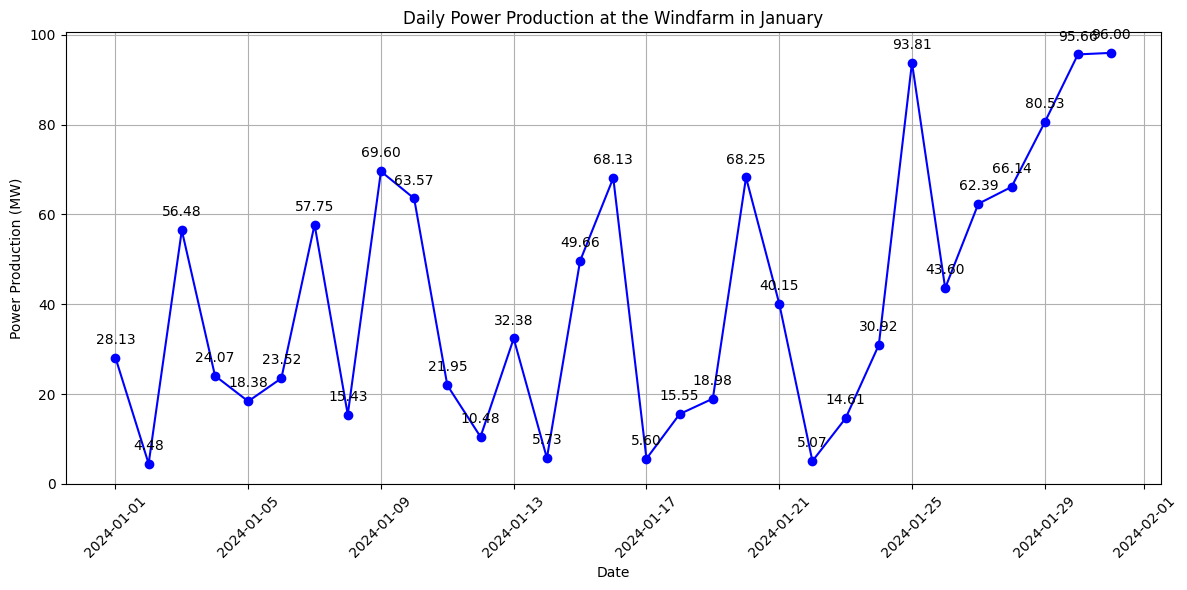

In [117]:
# e.	Create a visualization using the best practices we discussed showing power produced per day at the windfarm in January. 2 marks
newdf['Date'] = newdf.apply(lambda row: pd.to_datetime(f"2024-{row['Month']}-{row['Day']}-{row['Time']}"), axis=1)
newdf = newdf.resample('D', on='Date')['Power (MW)'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(newdf['Date'], newdf['Power (MW)'], marker='o', linestyle='-',color='b')
for i, txt in enumerate(newdf['Power (MW)']):
    plt.annotate(f"{txt:.2f}", (newdf['Date'].iloc[i], newdf['Power (MW)'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Daily Power Production at the Windfarm in January')
plt.xlabel('Date')
plt.ylabel('Power Production (MW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()